# Deeper dive into time series data


In [3]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
import datetime

SEED = 99

from sklearn import preprocessing, svm
from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_absolute_error as MAE, r2_score, mean_squared_error as MSE

import statsmodels.tsa.api as smt
import statsmodels.api as sm

# ## For Arima
import pmdarima

## For Lstm
# import tensorflow as tf

# # ## For Prophet
from fbprophet import Prophet

from warnings import filterwarnings

filterwarnings('ignore') #for the sake of posting online

In [635]:
feat_train = pd.read_csv('dengue_features_train.csv', parse_dates = ['week_start_date'])
label_train = pd.read_csv("dengue_labels_train.csv")

#Different versions of the same data for trying out different methods
data = feat_train.merge(label_train, on=['city', 'year', 'weekofyear'])
data_train = data.set_index(['city', 'year', 'weekofyear'])
data_monthly = data.set_index('week_start_date')

In [636]:
#Split data on city
data_sj = data_train.loc['sj']
data_iq = data_train.loc['iq']

## format datetime column
data_sj["date"] = pd.to_datetime(data_sj['week_start_date'], format='%d.%m.%Y')## create time series
ts = data_sj.groupby("date")["total_cases"].sum()

data_iq["date"] = pd.to_datetime(data_iq['week_start_date'], format='%d.%m.%Y')## create time series
ts_iq = data_iq.groupby("date")["total_cases"].sum()

In [637]:
data_iq.head()

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
2000 26              2000-07-01  0.192886  0.132257  0.340886  0.247200   
     27              2000-07-08  0.216833  0.276100  0.289457  0.241657   
     28              2000-07-15  0.176757  0.173129  0.204114  0.128014   
     29              2000-07-22  0.227729  0.145429  0.254200  0.200314   
     30              2000-07-29  0.328643  0.322129  0.254371  0.361043   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
2000 26                         25.41             296.740000   
     27                         60.61             296.634286   
     28                         55.52             296.415714   
     29                          5.60             295.357143   
     30                         62.76             296.432857   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
2000 26                     298.450000                   295.184286   
     27                     298.428571                   295.358571   
     28                     297.392857                   295.622857   
     29                     296.228571                   292.797143   
     30                     297.635714                   293.957143   

                 reanalysis_max_air_temp_k  ...  reanalysis_sat_precip_amt_mm  \
year weekofyear                             ...                                 
2000 26                              307.3  ...                         25.41   
     27                              306.6  ...                         60.61   
     28                              304.5  ...                         55.52   
     29                              303.6  ...                          5.60   
     30                              307.0  ...                         62.76   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
year weekofyear                                                             
2000 26                                      16.651429           8.928571   
     27                                      16.862857          10.314286   
     28                                      17.120000           7.385714   
     29                                      14.431429           9.114286   
     30                                      15.444286           9.500000   

                 station_avg_temp_c  station_diur_temp_rng_c  \
year weekofyear                                                
2000 26                   26.400000                10.775000   
     27                   26.900000                11.566667   
     28                   26.800000                11.466667   
     29                   25.766667                10.533333   
     30                   26.600000                11.480000   

                 station_max_temp_c  station_min_temp_c  station_precip_mm  \
year weekofyear                                                              
2000 26                        32.5                20.7                3.0   
     27                        34.0                20.8               55.6   
     28                        33.0                20.7               38.1   
     29                        31.5                14.7               30.0   
     30                        33.3                19.1                4.0   

                 total_cases       date  
year weekofyear                          
2000 26                    0 2000-07-01  
     27                    0 2000-07-08  
     28                    0 2000-07-15  
     29                    0 2000-07-22  
     30                    0 2000-07-29  

[5 rows x 23 columns]

In [6]:
#Resample on month
ts_sj_monthly = data_monthly.total_cases[data_monthly.city == 'sj'].resample('M').sum()
ts_iq_monthly = data_monthly.total_cases[data_monthly.city == 'iq'].resample('M').sum()

<AxesSubplot:xlabel='date'>

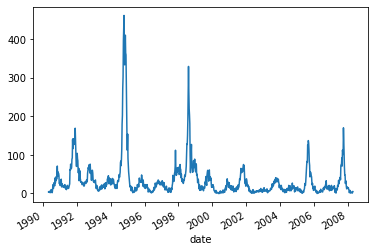

In [7]:
ts.plot()

<AxesSubplot:xlabel='date'>

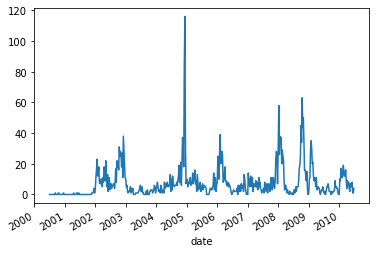

In [8]:
ts_iq.plot()

In [9]:
'''
Given the great irregularity of the inital flat case count (most 
likely a data capturing failure), I will just remove the data here 
before 2002.
'''

ts_iq = ts_iq["1-1-2002":]
ts_iq_monthly = ts_iq_monthly["1-1-2002":]

# Modeling: Prophet model

In [206]:
'''
Split train/test from any given data point.
:parameter
    :param ts: pandas Series
    :param test: num or str - test size (ex. 0.20) or index position
                 (ex. "yyyy-mm-dd", 1000)
:return
    ts_train, ts_test
'''
def split_train_test(ts, test=0.20, plot=True, figsize=(15,5)):
    ## define splitting point
    if type(test) is float:
        split = int(len(ts)*(1-test))
        perc = test
    elif type(test) is str:
        split = ts.reset_index()[ts.reset_index().iloc[:,0]==test].index[0]
        perc = round(len(ts[split:])/len(ts), 2)
    else:
        split = test
        perc = round(len(ts[split:])/len(ts), 2)
    print("--- splitting at index: ", split, "|", 
          ts.index[split], "| test size:", perc, " ---")
    
    ## split ts
    ts_train = ts.head(split)
    ts_test = ts.tail(len(ts)-split)
    if plot is True:
        fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, 
                               sharey=True, figsize=figsize)
        ts_train.plot(ax=ax[0], grid=True, title="Train", 
                      color="black")
        ts_test.plot(ax=ax[1], grid=True, title="Test", 
                     color="black")
        ax[0].set(xlabel=None)
        ax[1].set(xlabel=None)
        plt.show()
        
    return ts_train, ts_test

In [282]:
'''
Evaluation metrics for predictions.
:parameter
    :param dtf: DataFrame with columns raw values, fitted training  
                 values, predicted test values
:return
    dataframe with raw ts and forecast
'''
def utils_evaluate_forecast(dtf, title, plot=True, figsize=(20,13)):
    try:
        ## residuals
        dtf["residuals"] = dtf["ts"] - dtf["model"]
        dtf["error"] = dtf["ts"] - dtf["forecast"]
        dtf["error_pct"] = dtf["error"] / dtf["ts"]
        
        ## kpi
        residuals_mean = dtf["residuals"].mean()
        residuals_std = dtf["residuals"].std()
        error_mean = dtf["error"].mean()
        error_std = dtf["error"].std()
        mae = dtf["error"].apply(lambda x: np.abs(x)).mean()
        mape = dtf["error_pct"].apply(lambda x: np.abs(x)).mean()  
        mse = dtf["error"].apply(lambda x: x**2).mean()
        rmse = np.sqrt(mse)  #root mean squared error
        
        ## intervals
        dtf["conf_int_low"] = dtf["forecast"] - 1.96*residuals_std
        dtf["conf_int_up"] = dtf["forecast"] + 1.96*residuals_std
        dtf["pred_int_low"] = dtf["forecast"] - 1.96*error_std
        dtf["pred_int_up"] = dtf["forecast"] + 1.96*error_std
        
        ## plot
        if plot==True:
            fig = plt.figure(figsize=figsize)
            fig.suptitle(title, fontsize=20)   
            ax1 = fig.add_subplot(2,2, 1)
            ax2 = fig.add_subplot(2,2, 2, sharey=ax1)
            ax3 = fig.add_subplot(2,2, 3)
            ax4 = fig.add_subplot(2,2, 4)
            ### training
            dtf[pd.notnull(dtf["model"])][["ts","model"]].plot(color=["black","green"], title="Model", grid=True, ax=ax1)      
            ax1.set(xlabel=None)
            ### test
            dtf[pd.isnull(dtf["model"])][["ts","forecast"]].plot(color=["black","red"], title="Forecast", grid=True, ax=ax2)
            ax2.fill_between(x=dtf.index, y1=dtf['pred_int_low'], y2=dtf['pred_int_up'], color='b', alpha=0.2)
            ax2.fill_between(x=dtf.index, y1=dtf['conf_int_low'], y2=dtf['conf_int_up'], color='b', alpha=0.3)     
            ax2.set(xlabel=None)
            ### residuals
            dtf[["residuals","error"]].plot(ax=ax3, color=["green","red"], title="Residuals", grid=True)
            ax3.set(xlabel=None)
            ### residuals distribution
            dtf[["residuals","error"]].plot(ax=ax4, color=["green","red"], kind='kde', title="Residuals Distribution", grid=True)
            ax4.set(ylabel=None)
            plt.show()
            print("Training --> Residuals mean:", np.round(residuals_mean), " | std:", np.round(residuals_std))
            print("Test --> Error mean:", np.round(error_mean), " | std:", np.round(error_std),
                  " | mae:",np.round(mae), " | mape:",np.round(mape*100), "%  | mse:",np.round(mse), " | rmse:",np.round(rmse))
        
        return dtf[["ts","model","residuals","conf_int_low","conf_int_up", 
                    "forecast","error","pred_int_low","pred_int_up"]]
    
    except Exception as e:
        print("--- got error ---")
        print(e)

--- splitting at index:  655 | 2002-12-03 00:00:00 | test size: 0.3  ---


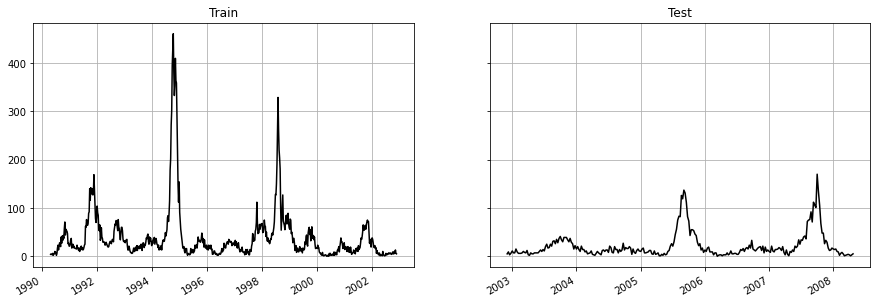

--- splitting at index:  309 | 2007-12-10 00:00:00 | test size: 0.3  ---


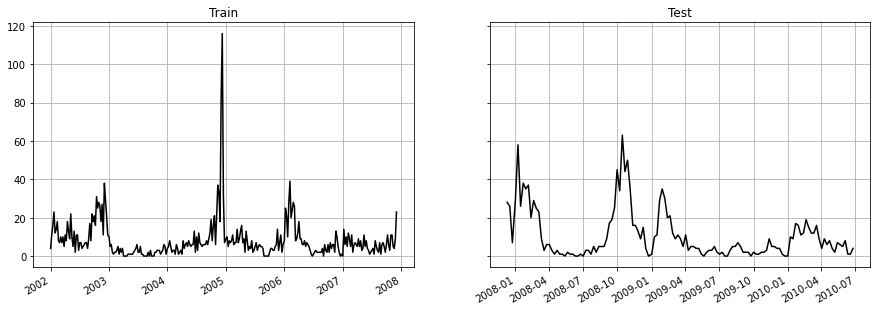

In [376]:
ts_train_sj, ts_test_sj = split_train_test(ts, test = 0.3)
ts_train_iq, ts_test_iq = split_train_test(ts_iq, test = 0.3)

# ts_train_sj, ts_test_sj = split_train_test(ts_sj_monthly, test = 0.2)


In [606]:
'''
Fits prophet on Business Data:
    y = trend + seasonality + holidays
:parameter
    :param dtf_train: pandas Dataframe with columns 'ds' (dates), 
             'y' (values), 'cap' (capacity if growth="logistic"), 
             other additional regressor
    :param dtf_test: pandas Dataframe with columns 'ds' (dates), 'y' 
                     (values), 'cap' (capacity if 
                      growth="logistic"), 
                      other additional regressor
    :param lst_exog: list - names of variables
    :param freq: str - "D" daily, "M" monthly, "Y" annual, "MS" 
                       monthly start ...
:return
    dtf with predictons and the model
'''
def fit_prophet(dtf_train, dtf_test, lst_exog=None, model=None, 
                freq="D", cap = None, figsize=(15,10)):
    ## train
    model.fit(dtf_train)
    
    ## test
    dtf_prophet = model.make_future_dataframe(periods=365*5, 
                  freq=freq, include_history=True)
    if cap:
        dtf_prophet['cap'] = cap
    dtf_scan = dtf_prophet.copy()    
    dtf_prophet = model.predict(dtf_prophet)
    dtf_train = dtf_train.merge(dtf_prophet[["ds","yhat"]], 
                how="left").rename(columns={'yhat':'model', 
                'y':'ts'}).set_index("ds")
    dtf_test = dtf_test.merge(dtf_prophet[["ds","yhat"]], 
                how="left").rename(columns={'yhat':'forecast',  
                'y':'ts'}).set_index("ds")
    
    ## evaluate
    dtf = dtf_train.append(dtf_test)
    dtf = utils_evaluate_forecast(dtf, figsize=figsize, title="Prophet")
    return dtf, model

In [652]:
dtf_train_sj = ts_train_sj.reset_index().rename(columns={"date":"ds", 
                                                   "total_cases":"y"})
dtf_test_sj = ts_test_sj.reset_index().rename(columns={"date":"ds", 
                                                 "total_cases":"y"})

dtf_train_sj['cap'] = 100
dtf_test_sj['cap'] = 100


dtf_train_iq = ts_train_iq.reset_index().rename(columns={"date":"ds", 
                                                   "total_cases":"y"})
dtf_test_iq = ts_test_iq.reset_index().rename(columns={"date":"ds", 
                                                 "total_cases":"y"})

# dtf_train_iq['cap'] = 30
# dtf_test_iq['cap'] = 30

ts_iq_rain = data_iq.groupby(["date",'precipitation_amt_mm'])["total_cases"].sum()
ts_iq_rain = ts_iq_rain['2002-01-01':]
ts_iq_rain = ts_iq_rain.reset_index().rename(columns={"date":"ds", 
                                                      "total_cases":"y",
                                                      "precipitation_amt_mm":"precp"})
ts_train_iq_rain, ts_test_iq_rain = split_train_test(ts_iq_rain, test = 0.3, plot=False)
# ts_test_iq_rain

ts_iq_weather = data_iq.groupby(["date",'precipitation_amt_mm', 'reanalysis_specific_humidity_g_per_kg'])["total_cases"].sum()
ts_iq_weather = ts_iq_weather['2002-01-01':]
ts_iq_weather = ts_iq_weather.reset_index().rename(columns={"date":"ds", 
                                                      "total_cases":"y",
                                                      "precipitation_amt_mm":"precp",
                                                      'reanalysis_specific_humidity_g_per_kg' : 'humid'
                                                        })

ts_iq_weather_train, ts_iq_weather_test = split_train_test(ts_iq_weather, test = 0.3, plot=False)
ts_iq_weather_train.info()

--- splitting at index:  306 | 306 | test size: 0.3  ---
--- splitting at index:  306 | 306 | test size: 0.3  ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      306 non-null    datetime64[ns]
 1   precp   306 non-null    float64       
 2   humid   306 non-null    float64       
 3   y       306 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 9.7 KB


In [526]:
model = Prophet(growth="logistic",
                changepoint_prior_scale= 0.05,
                seasonality_prior_scale = 10,
                seasonality_mode="multiplicative")            

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


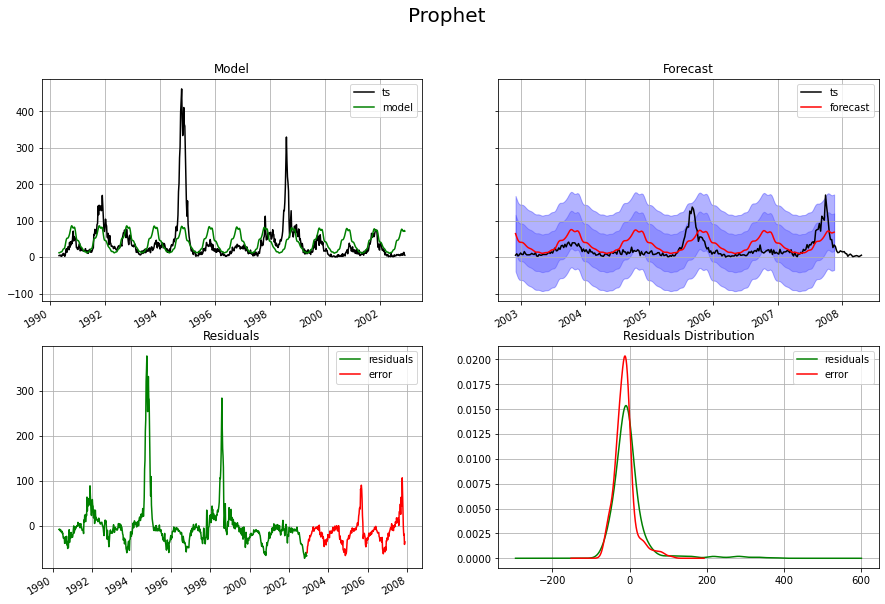

Training --> Residuals mean: -0.0  | std: 53.0
Test --> Error mean: -13.0  | std: 26.0  | mae: 23.0  | mape: inf %  | mse: 863.0  | rmse: 29.0
--- got error ---
"['mae'] not in index"


In [527]:
dtf_sj, model_sj,scan,prophet = fit_prophet(dtf_train_sj,
                               dtf_test_sj,
                               model=model,
                               freq='D',
                               cap=100)

In [302]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

cutoffs = pd.to_datetime(['1992-01-01', '1996-01-01', '2000-01-01'])

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'seasonality_mode': ['multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(growth = 'logistic', **params).fit(dtf_train_sj)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
print(tuning_results)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000016CA4B0AEE0>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000016CA4B0A610>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <co

   changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                    0.001                      0.1   multiplicative   
1                    0.001                      1.0   multiplicative   
2                    0.001                     10.0   multiplicative   
3                    0.010                      0.1   multiplicative   
4                    0.010                      1.0   multiplicative   
5                    0.010                     10.0   multiplicative   
6                    0.100                      0.1   multiplicative   
7                    0.100                      1.0   multiplicative   
8                    0.100                     10.0   multiplicative   

         mae  
0  12.762657  
1  11.778514  
2  11.779036  
3  12.955030  
4  11.767038  
5  11.764148  
6  30.006847  
7  17.823602  
8  17.669951  


In [306]:
best_params = all_params[np.argmin(maes)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


In [607]:
model_iq = Prophet(growth="linear",
                changepoint_prior_scale= 0.01, 
                seasonality_prior_scale= 10.0,
                seasonality_mode="additive")            

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


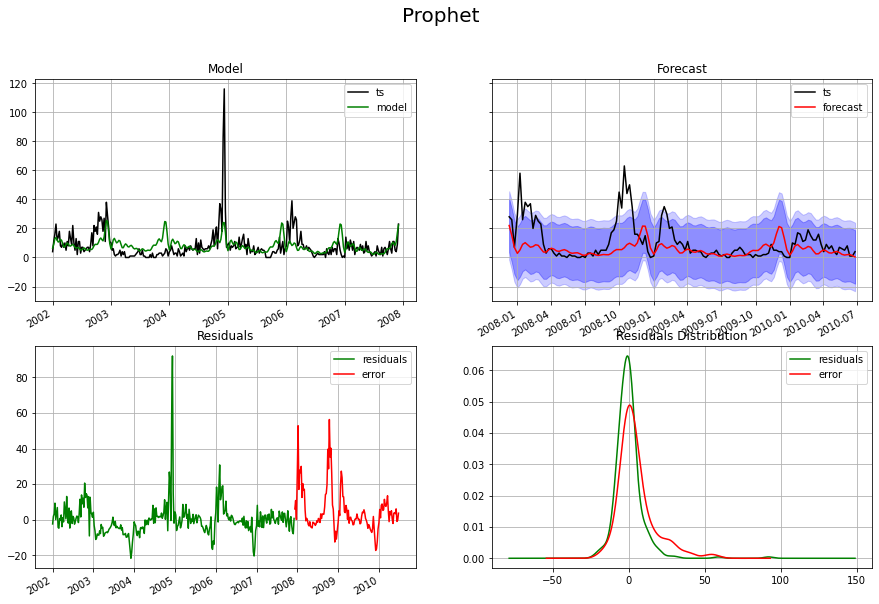

Training --> Residuals mean: 0.0  | std: 9.0
Test --> Error mean: 5.0  | std: 12.0  | mae: 8.0  | mape: inf %  | mse: 168.0  | rmse: 13.0
--- got error ---
"['mae'] not in index"


In [608]:
dtf_iq, model_iq = fit_prophet(dtf_train_iq,
                               dtf_test_iq,
                               model=model_iq,
                               freq='D')

In [609]:
data_iq_rain_avgs = data_iq.reset_index().groupby('weekofyear')['precipitation_amt_mm'].mean()
data_iq_rain_avgs = pd.DataFrame(data_iq_rain_avgs).reset_index()
data_iq_rain_avgs.columns = ['weekofyear', 'precp']
#nan for leap year (week 53) - fill with average of week 52 and week 1
data_iq_rain_avgs['precp'][52] = (data_iq_rain_avgs['precp'][0] + data_iq_rain_avgs['precp'][51]) / 2

data_iq_rain_avgs['precp']=(data_iq_rain_avgs['precp']-data_iq_rain_avgs['precp'].mean())/data_iq_rain_avgs['precp'].std()

data_iq_rain_avgs.tail()

,weekofyear,precp
48,49,-0.261288
49,50,1.453627
50,51,0.592341
51,52,1.547383
52,53,0.408375


In [651]:
data_iq_weather_avgs = data_iq.reset_index().groupby('weekofyear')['reanalysis_specific_humidity_g_per_kg'].mean()
data_iq_weather_avgs = pd.DataFrame(data_iq_weather_avgs).reset_index()
data_iq_weather_avgs.columns = ['weekofyear', 'humid']

#nan for leap year (week 53) - fill with average of week 52 and week 1
data_iq_weather_avgs['humid'][52] = (data_iq_weather_avgs['humid'][0] + data_iq_weather_avgs['humid'][51]) / 2

data_iq_weather_avgs['humid']=(data_iq_weather_avgs['humid']-data_iq_weather_avgs['humid'].mean())/data_iq_weather_avgs['humid'].std()

data_iq_weather_avgs.tail()

data_iq_weather_avgs = data_iq_weather_avgs.merge(data_iq_rain_avgs)
data_iq_weather_avgs.head()

,weekofyear,humid,precp
0,1,0.033444,-0.730633
1,2,0.422840,0.039082
2,3,0.652985,0.654060
3,4,0.288360,0.724288
4,5,0.309134,0.139262


In [776]:
model_iq = Prophet(growth="logistic",
                changepoint_prior_scale= 0.05, 
                seasonality_prior_scale= 5.0,
                seasonality_mode="additive")            

In [777]:
model_iq.add_regressor('precp')

model_iq.add_regressor('humid')

In [778]:
ts_iq_weather_train = ts_iq_weather_train[['ds','y','precp', 'humid']]
ts_iq_weather_train['cap']= 40
ts_iq_weather_test['cap']= 40

In [779]:
# model_iq.fit(ts_train_iq_rain)

model_iq.fit(ts_iq_weather_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [780]:
dtf_prophet = model_iq.make_future_dataframe(periods=365*5,freq='D', include_history=True)
dtf_prophet['weekofyear'] = dtf_prophet['ds'].dt.week
dtf_prophet['precp'],dtf_prophet['humid'] = np.nan,np.nan

dtf_prophet = dtf_prophet.merge(data_iq_weather_avgs, how='left', on='weekofyear', suffixes=['delete',''])
dtf_prophet.drop(['precpdelete','humiddelete'], axis=1, inplace=True)

dtf_prophet.columns = ['ds','weekofyear','precp','humid']
dtf_prophet.drop('weekofyear', axis=1, inplace=True)

dtf_prophet['cap'] = 40
dtf_prophet.head()

,ds,precp,humid,cap
0,2002-01-01,0.033444,-0.730633,40
1,2002-01-08,0.422840,0.039082,40
2,2002-01-15,0.652985,0.654060,40
3,2002-01-22,0.288360,0.724288,40
4,2002-01-29,0.309134,0.139262,40


In [781]:
dtf_prophet = model_iq.predict(dtf_prophet)

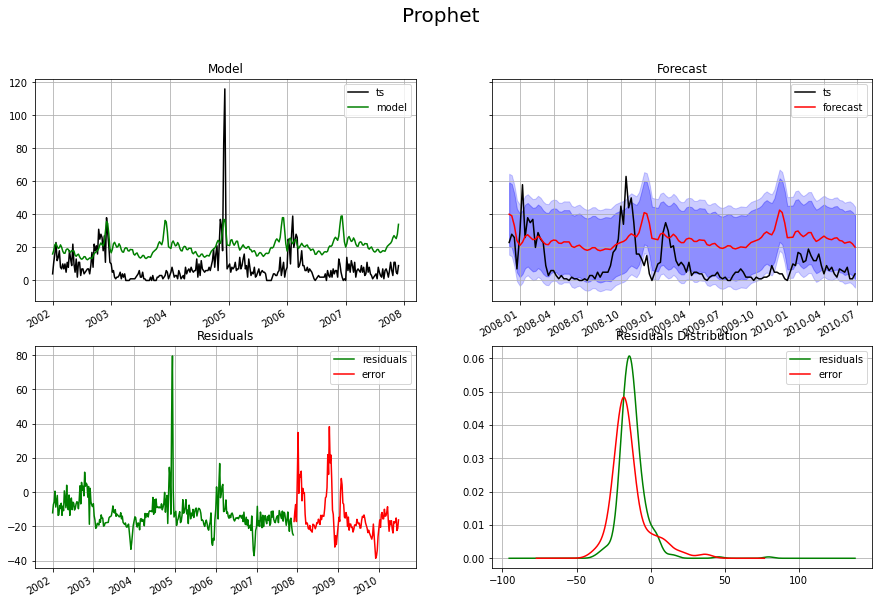

Training --> Residuals mean: -12.0  | std: 10.0
Test --> Error mean: -14.0  | std: 13.0  | mae: 17.0  | mape: inf %  | mse: 355.0  | rmse: 19.0
--- got error ---
"['mae'] not in index"


In [782]:
dtf_train = ts_iq_weather_train.merge(dtf_prophet[["ds","yhat"]], 
            how="left").rename(columns={'yhat':'model', 
            'y':'ts'}).set_index("ds")
dtf_test = ts_iq_weather_test.merge(dtf_prophet[["ds","yhat"]], 
            how="left").rename(columns={'yhat':'forecast',  
            'y':'ts'}).set_index("ds")

## evaluate
dtf = dtf_train.append(dtf_test)
dtf = utils_evaluate_forecast(dtf, figsize=(15,10), title="Prophet")